# Import 

In [1]:
from dask.distributed import LocalCluster

# https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389/12
cluster = LocalCluster(threads_per_worker=1)          # Fully-featured local Dask cluster
client = cluster.get_client()
client

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45911 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45911/status,
Dashboard: http://127.0.0.1:45911/status,Workers: 56
Total threads: 56,Total memory: 755.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46189,Workers: 56
Dashboard: http://127.0.0.1:45911/status,Total threads: 56
Started: Just now,Total memory: 755.78 GiB
Comm: tcp://127.0.0.1:43417,Total threads: 1
Dashboard: http://127.0.0.1:35271/status,Memory: 13.50 GiB
Nanny: tcp://127.0.0.1:45891,


In [2]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from pathlib import Path
from string import ascii_lowercase, ascii_uppercase

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import HTML, Image, display
from scipy import stats

In [4]:
%reload_ext watermark
%watermark --iversions -v -m

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.27.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 4.19.0-26-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 56
Architecture: 64bit

numpy      : 1.26.4
xarray     : 2024.3.0
sys        : 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
matplotlib : 3.9.2
IPython    : 8.27.0
pandas     : 2.1.4
distributed: 2024.4.1
scipy      : 1.12.0



# Constants

In [3]:
xr.set_options(keep_attrs=True)
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update({"font.size": 22})

# Functions

In [5]:
def deseasonalize_func(ds):
    time_var = "time"
    climatology = ds.groupby(time_var + ".month").mean(time_var)
    anomalies = ds.copy()
    for sel_var in list(ds.data_vars)[:]:
        if sel_var in ["O3_m", "H2O_m"]:
            anomalies[sel_var] = (
                (
                    ds[sel_var].groupby(time_var + ".month") - climatology[sel_var]
                ).groupby(time_var + ".month")
                / climatology[sel_var]
                * 100
            )
            anomalies[sel_var].attrs["units"] = "%"
        else:
            anomalies[sel_var] = (
                ds[sel_var].groupby(time_var + ".month") - climatology[sel_var]
            )
            anomalies[sel_var].attrs["units"] = ds[sel_var].attrs["units"]
    return anomalies


def anomalize_func(ds):
    time_var = "time"
    climatology = (
        ds.sel(time=slice("2022-01", "2022-12"))
        .groupby(time_var + ".month")
        .mean(time_var)
    )
    anomalies = ds.copy()
    for sel_var in list(ds.data_vars)[:]:
        if sel_var in ["O3_m", "H2O_m"]:
            anomalies[sel_var] = (
                (ds[sel_var] - climatology[sel_var]) / climatology[sel_var] * 100
            )
            anomalies[sel_var].attrs["units"] = "%"
        else:
            anomalies[sel_var] = ds[sel_var] - climatology[sel_var]
            anomalies[sel_var].attrs["units"] = ds[sel_var].attrs["units"]
    return anomalies

def fdr_threshold(pvalues, alpha=0.05):
    """Computes the FDR threshod after Wilks (2016)."""
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= (np.arange(1, n+1) / n * alpha), p, 0))


def process(ds, deseasonalize=True, upper_limit=0.1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(upper_limit, lower_limit))


def process_tpp(ds, deseasonalize=True, upper_limit=1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds = ds.rename({"var237": "tpp"})
    ds["tpp"] = ds["tpp"] / 100.0

    ds["tpp"].attrs["units"] = "hPa"
    ds["tpp"].attrs["long_name"] = "tropopause pressure"
    # ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds


def process_daily(ds, deseasonalize=False):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))


def process_daily_sd(ds, deseasonalize=False):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2022-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))


def map_month(m):
    if m == 2:
        m_str = "DJF"
    elif m == 5:
        m_str = "MAM"
    elif m == 8:
        m_str = "JJA"
    elif m == 11:
        m_str = "SON"
    else:
        m_str = "NaN"

    return m_str


def map_time_str(time):
    year_arr = time.dt.year.values
    month_arr = time.dt.month.values

    month_str_ls = list(map(map_month, month_arr))
    func = lambda x, y: str(x) + "-" + y
    date_str = list(map(func, year_arr, month_str_ls))

    return date_str


def integrate_wv(da):
    g = 9.81
    e = 0.622
    w = area_weights  # .mean(axis = 1)
    # from kg to g and then to Tg
    integral = (da * w * plev_diff * e / g).sum(["lat", "plev", "lon"]) * 1000 / 1e12

    return integral


EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.

    Simplified function from iris.coord.Coord.

    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth**2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.

    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def show_gif(fname):
    import base64

    from IPython import display

    with open(fname, "rb") as fd:
        b64 = base64.b64encode(fd.read()).decode("ascii")
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


def ttest_1samp(a, dim):
    """
    This is a two-sided test for the null hypothesis that the expected value
    (mean) of a sample of independent observations `a` is equal to the given
    population mean, `popmean`

    Inspired here: https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py#L3769-L3846

    Parameters
    ----------
    a : xarray
        sample observation
    popmean : float or array_like
        expected value in null hypothesis, if array_like than it must have the
        same shape as `a` excluding the axis dimension
    dim : string
        dimension along which to compute test

    Returns
    -------
    mean : xarray
        averaged sample along which dimension t-test was computed
    pvalue : xarray
        two-tailed p-value
    """
    n = a[dim].shape[0]
    df = n - 1
    # a_mean = a.mean(dim)
    # d = a_mean - popmean
    v = a.var(dim, ddof=1)
    denom = np.sqrt(v / float(n))

    t = a / denom
    prob = stats.distributions.t.sf(np.fabs(t), df) * 2
    prob_xa = xr.DataArray(prob, coords=a.coords)
    return prob_xa.squeeze()


# https://wiki.mpimet.mpg.de/doku.php?id=analysis:pot_pourri:statistics:controlling_fdr
def xr_multipletest(p, alpha=0.05, method="fdr_bh", **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests

    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

# Load dataset

## SAD

In [6]:
what = "aero2"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [8]:
opts = dict(
    paths=infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    # data_vars="minimal",
)
ds_wo_aero = xr.open_mfdataset(**opts).pipe(process, deseasonalize=False)
ds_wo_aero

/tmp/ipykernel_19631/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 60, lon: 192, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    SAD      (ens, time, plev, lat, lon) float32 1GB dask.array<chunksize=(1, 60, 26, 96, 192), meta=np.ndarray>
    sbaer    (ens, time, lat, lon) float32 44MB dask.array<chunksize=(1, 60, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Feb 28 17:20:51 2024: cdo cat oo3.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [9]:
opts = dict(
    paths=infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    # data_vars="minimal",
)
ds_w_aero = xr.open_mfdataset(**opts).pipe(process, deseasonalize=False)
ds_w_aero

/tmp/ipykernel_19631/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 60, lon: 192, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    SAD      (ens, time, plev, lat, lon) float32 1GB dask.array<chunksize=(1, 60, 26, 96, 192), meta=np.ndarray>
    sbaer    (ens, time, lat, lon) float32 44MB dask.array<chunksize=(1, 60, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Feb 28 16:09:24 2024: cdo cat oo3.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## water vapour

In [ ]:
what = "H2O_m"
gen_ls = infile_path.glob(f"socol4_htt1*{what}*")
infiles_w = sorted(
    infile_path.glob(f"socol4_htt1*{what}*"),
    key=lambda path: int(path.stem.rsplit("_")[1][3:]),
)
ens_name_ls = list(map(get_ens_name, infiles_w))


infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [100]:
what = "H2O_m"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [6]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_H2O_m_2021-2025_daily.nc')]

In [101]:
ds_w_wv = xr.open_mfdataset(
    infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    # chunks = dict(plev = 1, time = 365)
).pipe(
    process_daily, deseasonalize=False
)  # .chunk(plev = 1, time = 365)
# ds_w_wv["ens"] = ens_name_ls
ds_w_wv

Task exception was never retrieved
future: <Task finished name='Task-3183956458' coro=<Client._gather.<locals>.wait() done, defined at /hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3183956463' coro=<Client._gather.<locals>.wait() done, defined at /hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3183956466' coro=<Client._gat

KeyboardInterrupt: 

In [ ]:
ds_wo_wv = xr.open_mfdataset(
    infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    # chunks = dict(plev = 1, time = 365)
).pipe(process_daily, deseasonalize=False)
ds_wo_wv

In [10]:
lon = ds_w_wv["lon"]
lat = ds_w_wv["lat"]  # .values

area_weights = grid_cell_areas(lon, lat)  # , radius=radius)
plev_diff = ds_w_wv.plev.diff("plev") * 100  # in Pa
global_wv_w_ht = integrate_wv(ds_w_wv["H2O_m"]).load()
global_wv_wo_ht = integrate_wv(ds_wo_wv["H2O_m"]).load()

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

## tropopause

In [10]:
what = "tropopause"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [11]:
ds_w_tpp = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_w_tpp

/tmp/ipykernel_19631/3947749690.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 1850, lon: 192, lat: 96, ens: 20)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-31 2021-02-28 ... 2175-02-28
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 3GB 266.2 265.4 264.5 ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Fri May 10 15:31:40 2024: cdo cat ttsocol4_htt181.nc /scrat...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [12]:
ds_wo_tpp = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_wo_tpp

/tmp/ipykernel_19631/3947749690.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 1850, lon: 192, lat: 96, ens: 20)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-31 2021-02-28 ... 2175-02-28
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 3GB nan nan nan ... 269.5 270.2 270.8
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Fri May 10 15:31:52 2024: cdo cat ttsocol4_htt261.nc /scrat...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## NOx

In [86]:
what = "NOx_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))
infiles_w

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt12_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt16_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt19_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt11_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt15_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt13_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt17_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt10_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt14_NOx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt18_NOx_mm_zon_2021-2025.nc')]

In [87]:
ds_w_nox = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit = 0.1)
    .load()
)
ds_w_nox

/tmp/ipykernel_51336/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 36MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    NO_m     (ens, time, plev, lat, lon) float32 6MB 4.557e-10 ... 6.096e-11
    NO2_m    (ens, time, plev, lat, lon) float32 6MB 2.561e-09 ... 8.171e-12
    HNO3_m   (ens, time, plev, lat, lon) float32 6MB 3.672e-13 ... 7.394e-11
    NO3_m    (ens, time, plev, lat, lon) float32 6MB 1.811e-12 ... 6.246e-16
    N2O5_m   (ens, time, plev, lat, lon) float32 6MB 2.669e-14 ... 6.95e-16
    N2O_m    (ens, time, plev, lat, lon) float32 6MB 9.409e-10 ... 3.347e-07
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 15:51:11 2024: cdo cat Postproc_example-NOx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [88]:
ds_wo_nox = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit = 0.1)
    .load()
)
ds_wo_nox

/tmp/ipykernel_51336/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 36MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    NO_m     (ens, time, plev, lat, lon) float32 6MB nan nan ... 6.83e-11
    NO2_m    (ens, time, plev, lat, lon) float32 6MB nan nan ... 1.164e-11
    HNO3_m   (ens, time, plev, lat, lon) float32 6MB nan nan ... 1.434e-10
    NO3_m    (ens, time, plev, lat, lon) float32 6MB nan nan ... 1.221e-15
    N2O5_m   (ens, time, plev, lat, lon) float32 6MB nan nan ... 2.656e-15
    N2O_m    (ens, time, plev, lat, lon) float32 6MB nan nan ... 3.338e-07
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 15:51:41 2024: cdo cat Postproc_example-NOx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## Brx

In [37]:
what = "Brx_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [570]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_Brx_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_Brx_mm_zon_2021-2025.nc')]

In [38]:
ds_w_brx = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False)
    .load()
)
ds_w_brx

/tmp/ipykernel_51336/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 30MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    BrO_m    (ens, time, plev, lat, lon) float32 6MB 6.736e-12 ... 8.219e-13
    BrNO3_m  (ens, time, plev, lat, lon) float32 6MB 1.741e-14 ... 1.854e-13
    BrCl_m   (ens, time, plev, lat, lon) float32 6MB 6.278e-13 ... 8.335e-17
    HOBr_m   (ens, time, plev, lat, lon) float32 6MB 8.389e-12 ... 2.594e-13
    Br_m     (ens, time, plev, lat, lon) float32 6MB 1.518e-13 ... 1.554e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 15:28:05 2024: cdo cat Postproc_example-Brx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [39]:
ds_wo_brx = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False)
    .load()
)
ds_wo_brx

/tmp/ipykernel_51336/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
2024-06-14 15:51:47,173 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39849' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-HOBr_m-6804fe156d4a2016d8903c1e72da80f9', 'original-open_dataset-Br_m-6804fe156d4a2016d8903c1e72da80f9', 'original-open_dataset-BrNO3_m-0b096a35d7ed265755429f81a2c64bf1', 'original-open_dataset-BrCl_m-15b29cdd4a45f6fc8c52278702251c94', 'original-open_dataset-BrO_m-c636772cfda7bd05002f13061aa82752', 'original-open_dataset-BrCl_m-1b433d3d3f2e2bc10cd7d392ab01cb48', 'original-open_dataset-BrNO3_m-d6082e22e8c4c254024437dea215398d'} (stimulus_id='handle-worker-cleanup-1718373107.1734455')
2024-06-14 15:51:47,208 - distributed.nanny - WARNING - Restarting worker


<xarray.Dataset> Size: 30MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    BrO_m    (ens, time, plev, lat, lon) float32 6MB nan nan ... 9.14e-13
    BrNO3_m  (ens, time, plev, lat, lon) float32 6MB nan nan ... 2.356e-13
    BrCl_m   (ens, time, plev, lat, lon) float32 6MB nan nan ... 9.279e-17
    HOBr_m   (ens, time, plev, lat, lon) float32 6MB nan nan ... 2.462e-13
    Br_m     (ens, time, plev, lat, lon) float32 6MB nan nan ... 1.615e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 15:28:30 2024: cdo cat Postproc_example-Brx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## Chemistry + dynamics

In [13]:
what = "chem_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [15]:
infiles_w

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt18_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt19_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt17_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt16_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt14_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt15_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt10_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt11_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt13_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt12_chem_mm_zon_2021-2025.nc')]

In [16]:
ds_wo_chem = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1, lower_limit = 1000)
    .load()
)
ds_wo_chem

/tmp/ipykernel_19631/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 41MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 44, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 352B 0.1112 0.2315 0.4259 ... 939.7 971.4 995.4
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 10MB nan nan nan ... nan nan
    u_m      (ens, time, plev, lat, lon) float32 10MB nan nan nan ... nan nan
    O3_m     (ens, time, plev, lat, lon) float32 10MB nan nan nan ... nan nan
    H2O_m    (ens, time, plev, lat, lon) float32 10MB nan nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Feb 29 16:07:22 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [17]:
ds_w_chem = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1, lower_limit = 1000)
    .load()
)
ds_w_chem

/tmp/ipykernel_19631/3947749690.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 41MB
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 44, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 8B 0.0
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 352B 0.1112 0.2315 0.4259 ... 939.7 971.4 995.4
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 10MB 254.4 253.9 ... nan nan
    u_m      (ens, time, plev, lat, lon) float32 10MB 2.536 4.23 ... nan nan
    O3_m     (ens, time, plev, lat, lon) float32 10MB 1.726e-06 ... nan
    H2O_m    (ens, time, plev, lat, lon) float32 10MB 3.416e-06 ... nan
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Mar 12 10:25:13 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

# Visualization

## Stratospheric WV

In [16]:
infiles_nudged = list(infile_path.glob(f"socol4_ht6_*H2O_m*daily*"))
infiles_nudged

[PosixPath('/scratch/snx3000/akuchar/ht/socol4_ht6_H2O_m_2022-2022_daily.nc')]

In [17]:
ds_sd = xr.open_dataset(
    infiles_nudged[0],
).pipe(
    process_daily_sd
)  # .load()
ds_sd

<xarray.Dataset>
Dimensions:  (time: 339, lon: 192, lat: 96, plev: 17)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-05
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 1.0 1.215 1.929 2.957 ... 59.64 74.06 91.02 100.0
Data variables:
    H2O_m    (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 17:48:59 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [18]:
infiles_nudged = list(infile_path.glob(f"socol4_ht2_*H2O_m*daily*"))
infiles_nudged

[PosixPath('/scratch/snx3000/akuchar/ht/socol4_ht2_H2O_m_2022-2022_daily.nc')]

In [19]:
ds_sd2 = xr.open_dataset(
    infiles_nudged[0],
).pipe(
    process_daily_sd
)  # .load()
ds_sd2

<xarray.Dataset>
Dimensions:  (time: 365, lon: 192, lat: 96, plev: 17)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 1.0 1.215 1.929 2.957 ... 59.64 74.06 91.02 100.0
Data variables:
    H2O_m    (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 17:58:53 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [84]:
global_wv_sd_ht = integrate_wv(ds_sd["H2O_m"]).load()
global_wv_sd2_ht = integrate_wv(ds_sd2["H2O_m"]).load()

NameError: name 'ds_sd' is not defined

In [11]:
global_wv_sd_ht_fromIMP7 = pd.read_csv(
    "socol4_ht2_intergatedWV.csv"
)  # xr.open_dataset('socol4_ht2_intergatedWV.nc', engine = 'netcdf4')
ds_wvi_sd = global_wv_sd_ht_fromIMP7.to_xarray()  # .set_index({'index':'time'})#['WV']
ds_wvi_sd["index"] = pd.date_range(
    "2022-01-01", freq="D", periods=ds_wvi_sd.index.shape[0]
)
ds_wvi_sd = ds_wvi_sd["WV"].rename({"index": "time"}) * -1
ds_wvi_sd

<xarray.DataArray 'WV' (time: 365)> Size: 3kB
array([1444.6291207 , 1443.80743007, 1442.93772717, 1442.31481505,
       1442.2263961 , 1442.20526343, 1441.99583271, 1441.85703148,
       1441.51584476, 1441.35274697, 1440.9826484 , 1440.64006453,
       1439.83296673, 1438.27055329, 1547.34453971, 1592.15222696,
       1591.71148386, 1591.53101191, 1591.71620276, 1592.08147244,
       1591.96883968, 1591.60641261, 1590.92915787, 1590.25496861,
       1589.68561577, 1589.1710184 , 1588.38985315, 1586.65028185,
       1585.35318736, 1584.90119548, 1583.97997575, 1583.99346541,
       1583.74499907, 1583.3665917 , 1583.00134358, 1583.26536961,
       1583.67635951, 1583.94242901, 1584.54699391, 1585.14508865,
       1585.51901319, 1586.0058372 , 1586.37384873, 1586.85581179,
       1587.3098016 , 1587.17964368, 1586.4055313 , 1585.58064381,
       1584.8902452 , 1584.48201455, 1584.57587772, 1584.68290452,
       1584.38902974, 1584.32135792, 1584.57212386, 1584.7256463 ,
       1585.0918541 , 1585.33347283, 1585.22996337, 1584.63514546,
       1584.10313296, 1583.3615035 , 1582.83360397, 1582.54982532,
       1582.07950395, 1581.83637888, 1581.79079461, 1581.78333413,
       1581.45688223, 1580.88841337, 1580.47386466, 1580.27805322,
       1580.31973833, 1579.98398485, 1579.16213296, 1578.56341644,
       1578.22103299, 1577.94524478, 1577.69283941, 1577.70178924,
...
       1653.99433342, 1654.25620831, 1654.8096169 , 1655.21882318,
       1655.15613325, 1654.8426036 , 1654.61376912, 1654.4278459 ,
       1653.94145556, 1654.21879776, 1654.49233781, 1654.31591383,
       1654.95485846, 1655.84037324, 1656.59892454, 1657.21268591,
       1657.54373041, 1657.97157141, 1658.44737106, 1658.18618093,
       1657.63290216, 1657.02117236, 1657.21186399, 1657.24796907,
       1656.73687304, 1655.84851345, 1654.76183454, 1653.82180311,
       1653.2623489 , 1652.23934417, 1652.24686757, 1652.4118301 ,
       1652.48497312, 1652.14338681, 1652.11025636, 1651.9398755 ,
       1651.27164617, 1650.24023998, 1649.57030009, 1649.65704784,
       1649.54986392, 1649.50694787, 1648.90970586, 1648.58907261,
       1648.16952902, 1648.00238273, 1648.21232323, 1648.64492093,
       1648.59019901, 1648.18160685, 1647.4887389 , 1647.1405051 ,
       1647.04536375, 1647.21191788, 1647.50432543, 1647.33325516,
       1646.7259135 , 1645.9550603 , 1645.61356579, 1645.72081814,
       1645.64891554, 1645.28817689, 1644.85628322, 1644.51330331,
       1643.94527718, 1643.66137929, 1643.82789048, 1643.45018448,
       1642.26695831, 1640.65004488, 1639.8384685 , 1639.51885108,
       1638.86957417, 1638.586546  , 1638.30571506, 1637.58926256,
       1635.99861697])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2022-01-01 2022-01-02 ... 2022-12-31

In [14]:
ds_scream = xr.open_dataset("scream_burden.nc")
ds_scream

<xarray.Dataset> Size: 4kB
Dimensions:    (time: 240)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2022-01-01 ... 2022-01-30T21:00:00
Data variables:
    wv_burden  (time) float64 2kB ...

In [211]:
import scipy.optimize
# https://gist.github.com/JCardenasRdz/cd2b0e8cc71913b6e15abcf40ea96b53

def exponential(x, a, b):
    return a * np.exp(-x * b)

In [229]:
def exp_decay(parameters, xdata):
    """
    Calculate an exponetial decay of the form:
    S= a * exp(-xdata/b)
    """
    a = parameters[0]
    b = parameters[1]
    return a * np.exp(-(xdata - 2023) * b)


def residuals(parameters, x_data, y_observed, func):
    """
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    """
    return func(parameters, x_data) - y_observed

In [306]:
x0 = [1, 1]

y_array_exp = (
    diff.sel(time=slice("2023-01-01", "2025-12-31"))
    .mean("ens")
    .resample(time="1M")
    .mean()
)
x_array = np.linspace(0, 1, y_array_exp.time.shape[0])
x_array = np.linspace(2023, 2026, y_array_exp.time.shape[0])

OptimizeResult = scipy.optimize.least_squares(
    residuals, x0, args=(x_array, y_array_exp.values, exp_decay)  # bounds = (0,2),
)
parameters_estimated = OptimizeResult.x


# Estimate data based on the solution found
y_data_predicted = exp_decay(parameters_estimated, x_array)

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [475]:
parameters_estimated[1]

0.572054284147313

In [476]:
1 / parameters_estimated[1] *np.log(2)   # *x_array

1.2116807788497377

In [477]:
1 / parameters_estimated[1] /np.log(2)   # *x_array

2.5219547879785598

strat_WV_mass_htt-vs-M2SCREAM-vs-nudged_daily_202201.pdf


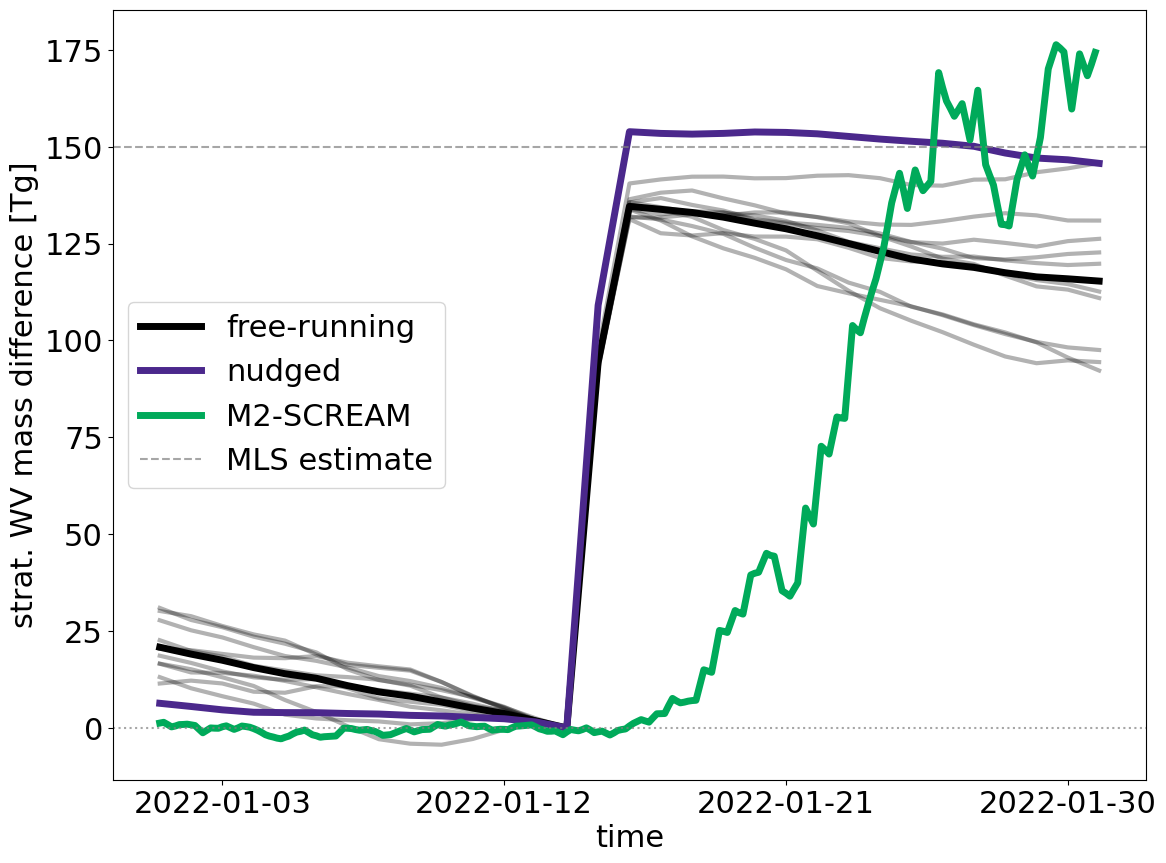

In [320]:
index = 13

temp = global_wv_w_ht.sel(time=slice("2022-01-01", "2022-01-31"))  # .mean('ens')
temp_em = temp.mean("ens")
p = (temp - temp[:, index]).plot.line(hue="ens", size=10, lw=3, c="k", alpha=0.3)
ax = p[0].axes
(temp_em - temp_em[index]).plot.line(ax=ax, c="k", lw=5, label="free-running")

# global_wv_sd_ht_sel = global_wv_sd_ht.sel(time = slice(None,'2022-01-31'))
# (global_wv_sd_ht_sel-global_wv_sd_ht_sel[index]).plot(ax = ax, c = 'gray', lw = 10, alpha = 0.5)

ds_wvi_sd_sel = ds_wvi_sd.sel(time=slice(None, "2022-01-31"))
(ds_wvi_sd_sel - ds_wvi_sd_sel[index]).plot(
    ax=ax, c=(75 / 255, 40 / 255, 140 / 255), lw=5, alpha=1, label="nudged"
)

temp = ds_scream["wv_burden"].sel(time=slice(None, "2022-01-31"))
(temp - temp[index]).plot(ax=ax, c=(0, 170 / 255, 90 / 255), lw=5, label="M2-SCREAM")

ax.axhline(150, ls="--", c="gray", alpha=0.7, label="MLS estimate")
ax.axhline(0, ls=":", c="gray", alpha=0.7)
ax.legend()
ax.set_ylabel("strat. WV mass difference [Tg]")


locator_daily = mdates.DayLocator(interval=9)
fmt = mdates.DateFormatter("%Y-%m-%d")
X = ax.xaxis
# X.set_major_locator(mdates.MonthLocator())#
X.set_major_locator(locator_daily)
X.set_major_formatter(fmt)

output = f"strat_WV_mass_htt-vs-M2SCREAM-vs-nudged_daily_202201.pdf"
print(output)
plt.savefig(output, bbox_inches="tight")

In [295]:
ylim = ax.get_ylim()

/tmp/ipykernel_47342/3708055234.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t_array = pd.date_range(str(s_year), str(e_year), freq="1M")


strat_WV_mass_htt_decay.pdf


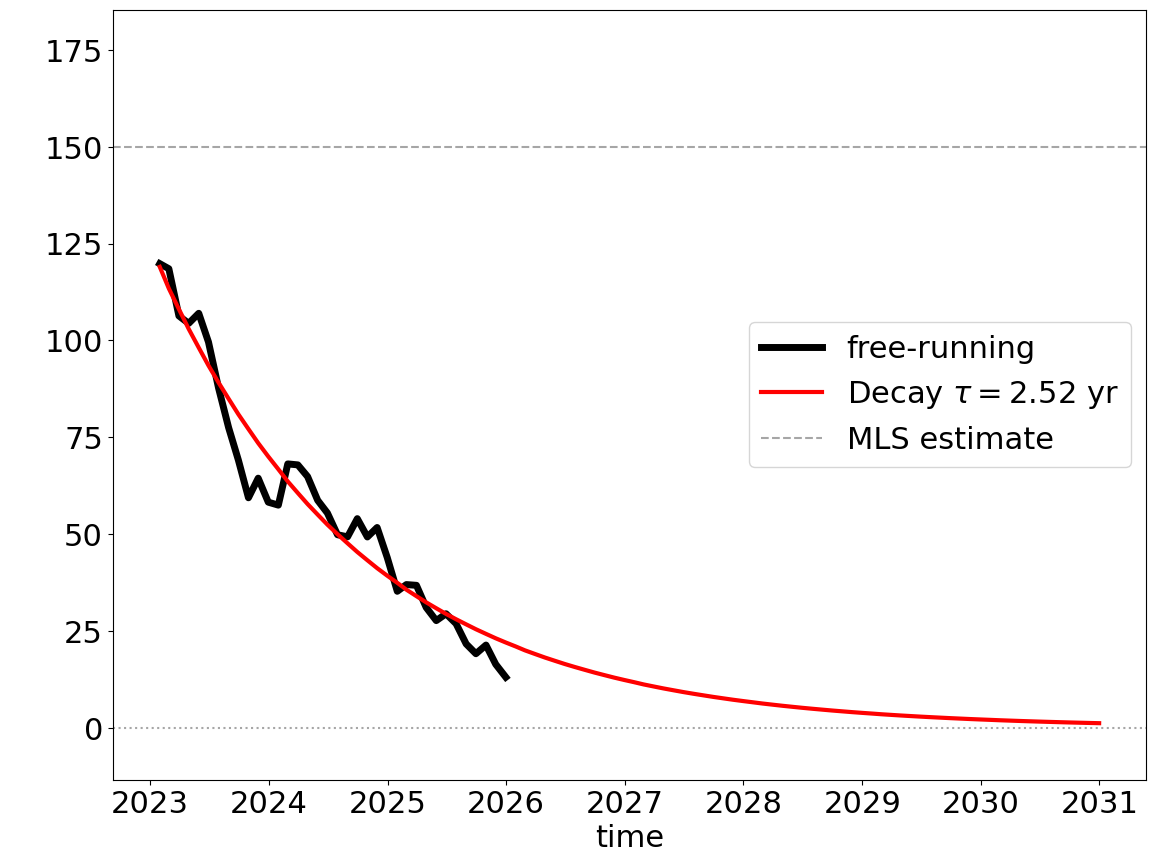

In [482]:
p = y_array_exp.plot(size=10, c="k", lw=5, label="free-running")
ax = p[0].axes
# diff.sel(time=slice("2022-01-01", "2025-12-31")).mean('ens').resample(time = '1M').mean().plot()
tau = 1 / parameters_estimated[1] /np.log(2)   # *x_array
s_year = 2023
e_year = 2031
n_years = e_year - s_year
x_array = np.linspace(s_year, e_year, n_years * 12)
t_array = pd.date_range(str(s_year), str(e_year), freq="1M")
da_exp = xr.DataArray(
    exp_decay(parameters_estimated, x_array), coords=dict(time=("time", t_array))
)
da_exp.plot(color="r", label="Decay"+r" $\tau=$"+f"{tau.round(2)} yr", lw=3)

ax.set_ylim(*ylim)
ax.axhline(150, ls="--", c="gray", alpha=0.7, label="MLS estimate")
ax.axhline(0, ls=":", c="gray", alpha=0.7)
ax.set_ylabel("asdasd", color="white")
ax.legend()
ax.text(
    0.95,
    0.05,
    ascii_uppercase[1],
    transform=ax.transAxes,
    fontsize=20,
    fontweight="bold",
    va="top",
    bbox={"alpha": 0.7, "facecolor": "white"},


output = f"strat_WV_mass_htt_decay.pdf"
print(output)
plt.savefig(output, bbox_inches="tight")

## Differences

In [25]:
time_slice = slice("2022-01", "2025-12-31")
how_rt = "Q-NOV"  # "1Q"

sel_dict = dict(time=time_slice, lat=slice(None, None))
da_w_tpp = (
    ds_w_tpp["tpp"]
    .sel(**sel_dict)
    .mean(["lon", "ens"])
    .resample(time=how_rt)
    .mean()
    .squeeze()
)
da_w_tpp["time"] = map_time_str(da_w_tpp.time)
da_w_tpp

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 'tpp' (time: 17, lat: 96)> Size: 7kB
array([[238.74274, 242.21326, 242.81473, ..., 265.8898 , 263.3067 ,
        260.25922],
       [239.39418, 239.03267, 240.11699, ..., 265.14963, 264.30637,
        264.22284],
       [234.48238, 235.971  , 238.00328, ..., 269.48438, 271.64346,
        274.49966],
       ...,
       [246.52141, 247.36414, 248.30975, ..., 270.75095, 272.15262,
        273.3386 ],
       [249.9034 , 249.21228, 250.23083, ..., 270.82715, 272.94653,
        273.8973 ],
       [247.86514, 250.41495, 252.1738 , ..., 268.5114 , 270.94025,
        271.9072 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * time     (time) <U8 544B '2022-DJF' '2022-MAM' ... '2025-SON' '2026-DJF'
Attributes:
    code:              237
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    units:             hPa
    long_name:         tropopause pressure

### SAD + H2O

#### Zonal mean

In [26]:
time_slice = slice("2022-01", "2023-12", 2)
time_slice = slice("2022-01", "2024-12-31")
how_rt = "Q-NOV"  # "1Q"

sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "SAD"
conv = 1e6  # to ppmv

arr1 = (
    ds_w_aero[sel_var].sel(**sel_dict).resample(time=how_rt).mean().mean(["lon"]).load()
)
arr2 = (
    ds_wo_aero[sel_var]
    .sel(**sel_dict)
    .resample(time=how_rt)
    .mean()
    .mean(["lon"])
    .load()
)
diff = (arr1 - arr2).mean("ens")  # *conv
diff["time"] = map_time_str(diff.time)
diff.attrs['units'] = r'$\mathrm{\mu m^2/cm^3}$'
diff.attrs['long_name'] = 'SAD'

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

sel_var2 = "H2O_m"
arr1 = ds_w_chem[sel_var2].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
arr2 = (
    ds_wo_chem[sel_var2].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
)
diff2 = (arr1 - arr2).mean("ens") * conv
# diff2 = diff2.resample(time=how_rt).mean()
diff2["time"] = map_time_str(diff2.time)
t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff2_pv = xr.DataArray(p_values, coords=diff2.coords)

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(


In [23]:
diff

<xarray.DataArray 'SAD' (time: 13, plev: 26, lat: 96)> Size: 130kB
array([[[ 9.18542628e-18, -6.88154464e-18, -7.72871739e-18, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.01013867e-11, -2.25500504e-11, -2.53270634e-11, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.92217497e-10,  2.85107538e-09,  1.29958266e-09, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.29500419e-01,  8.10528770e-02,  5.94858155e-02, ...,
          7.34155625e-02,  7.63403177e-02,  8.15831423e-02],
        [ 4.10717785e-01,  3.43734473e-01,  3.50038528e-01, ...,
          9.05805379e-02,  1.05659269e-01,  1.24176264e-01],
        [ 3.31510514e-01,  2.96770394e-01,  3.16138208e-01, ...,
          4.45923321e-02,  4.96135466e-02,  3.90719399e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
          6.80979937e-02,  6.38783202e-02,  5.36002405e-02],
        [ 3.93723957e-02,  4.78045233e-02,  3.90460975e-02, ...,
          3.69845144e-02,  4.64792252e-02,  4.45279106e-02],
        [ 1.50660994e-02,  2.37469077e-02,  2.05363035e-02, ...,
          8.63538757e-02,  1.19612023e-01,  1.28081486e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.97252777e-15,  3.35147284e-15,  2.96558305e-15, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.57941088e-09,  6.39446451e-09,  5.65820368e-09, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 4.32128608e-01,  4.23759133e-01,  4.33139414e-01, ...,
          1.43783987e-01,  1.28404379e-01,  1.22776352e-01],
        [ 2.21038342e-01,  2.17664033e-01,  2.35583454e-01, ...,
         -6.84619397e-02, -8.80551487e-02, -1.10674739e-01],
        [ 9.54548866e-02,  7.84268379e-02,  8.53752866e-02, ...,
         -1.05418541e-01, -1.16207562e-01, -1.31828845e-01]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
  * time     (time) <U8 416B '2022-DJF' '2022-MAM' ... '2024-SON' '2025-DJF'
Attributes:
    long_name:         SAD
    units:             $\mathrm{\mu m^2/cm^3}$
    code:              103
    table:             199
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    cell_methods:      time: mean
    institution:       MPIMET

/tmp/ipykernel_19631/3346766526.py:52: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


SAD+H2O_m_time-evolution-diff_mm_zon-htt-new_globally2.pdf


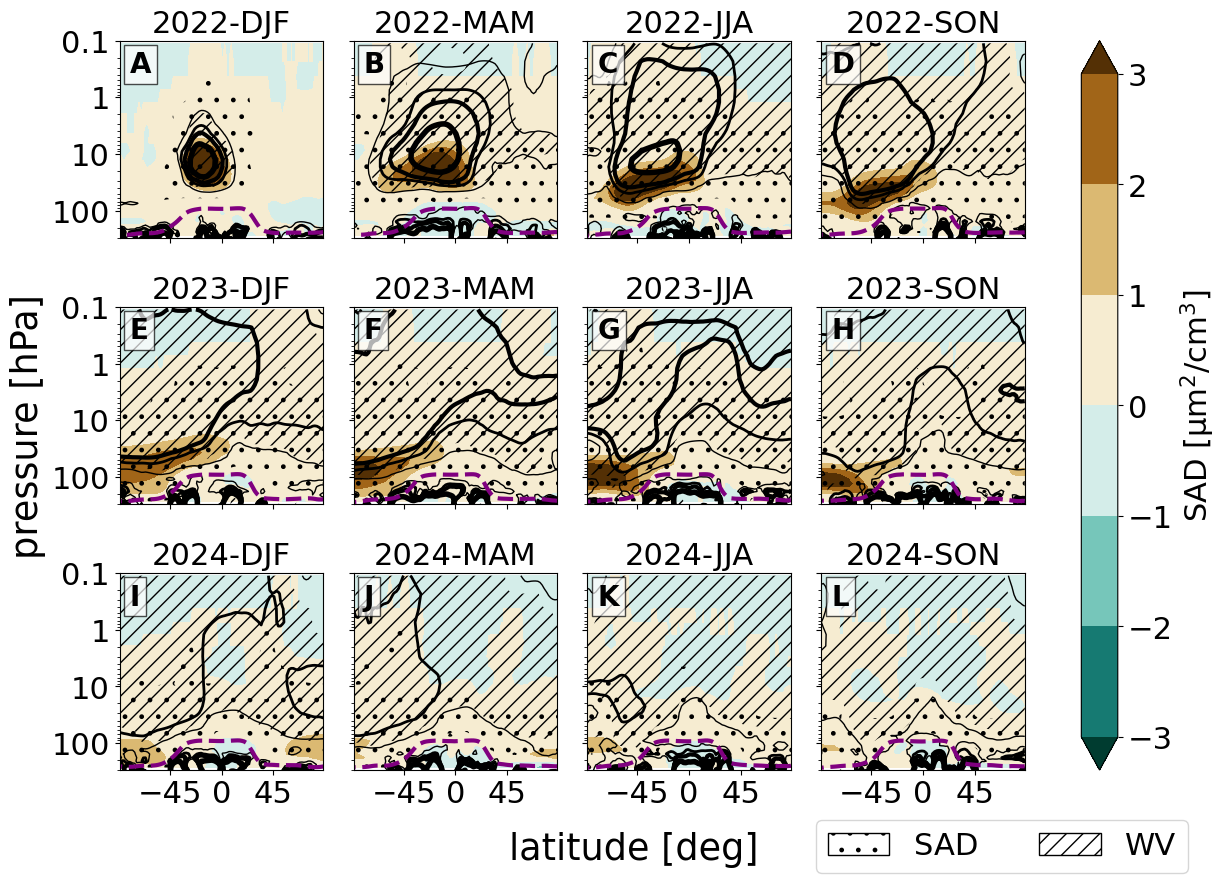

In [28]:
p = diff[:-1].plot.contourf(
    x="lat", col="time", yincrease=False, col_wrap=4, robust=True, cmap="BrBG_r",
    vmax = 3, extend = 'both'
    #cbar_kwargs = dict(orientation = 'horizontal')
)

p.data = diff2[:-1]
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0.1, 0.5, 1, 3],
    linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)

sad_pv = xr_multipletest(diff_pv)[1]
p.data = sad_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)

wv_pv = xr_multipletest(diff2_pv)[1]
p.data = wv_pv  # ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=["//", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]")

plt.ylim(300, .1)
plt.yscale("log")

lat = da_w_tpp.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, +45])
    ax.plot(lat, da_w_tpp.sel(**sel_dict), color="purple", ls="--", lw=3)

    if i == 11:
        proxy = [
            plt.Rectangle((0, 0), 1, 1, fill=None, hatch="."),
            plt.Rectangle((0, 0), 1, 1, fill=None, hatch="//"),
        ]
        ax.legend(proxy, ["SAD", "WV"], bbox_to_anchor=(-.1, -0.6), loc="lower left", ncols = 2)
outfile = f"{sel_var}+{sel_var2}_time-evolution-diff_mm_zon-htt-new_globally2.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

### HOBr

In [40]:
time_slice = slice("2022-01", "2023-12", 2)
time_slice = slice("2022-01", "2024-12-31")
how_rt = "Q-NOV"  # "1Q"

sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "HOBr_m"


arr1 = ds_w_brx[sel_var].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
arr2 = ds_wo_brx[sel_var].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")
diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)


arr = arr1.resample(time=how_rt).mean().squeeze().mean("ens")
arr["time"] = map_time_str(arr.time)

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(


/tmp/ipykernel_51336/1495199590.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


HOBr_m_time-evolution-diff_mm_zon-htt-new-globally.pdf


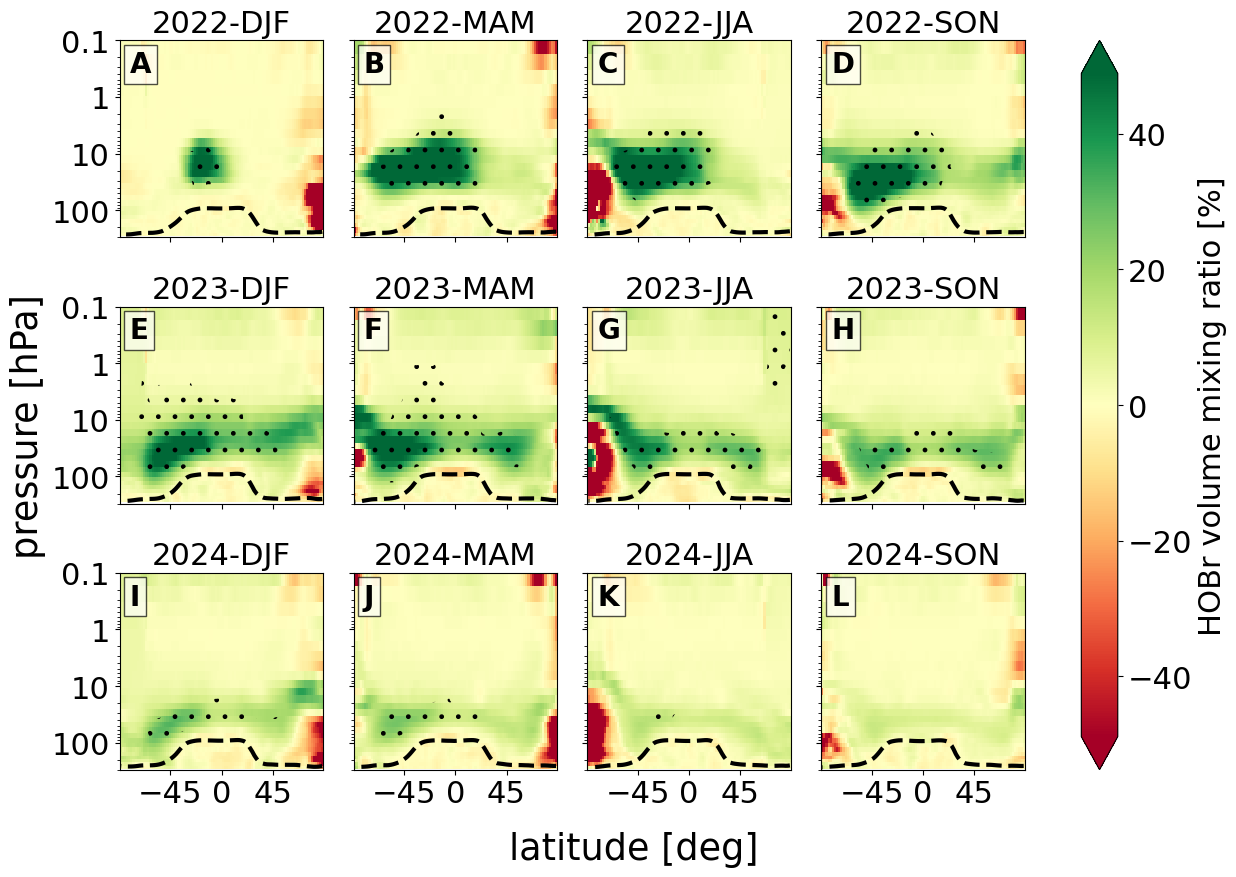

In [48]:
p = diff[:-1].plot(
    x="lat", col="time", yincrease=False, col_wrap=4, robust=True, cmap="RdYlGn"
)
levs = [5, 10, 20, 50]
nl = len(levs)

p.data = arr
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=levs,
    linewidths=np.linspace(1, 3, nl),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[-50, -20, -10, -5],
    linewidths=np.linspace(3, 1, nl),
    linestyles="dashed",
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)

u_pv = xr_multipletest(diff_pv)[1]
p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)

p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]")

plt.ylim(300, .1)
plt.yscale("log")

lat = da_w_tpp.lat.values
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])
    ax.plot(lat, da_w_tpp.sel(**sel_dict), 'k--', lw  = 3)


outfile = f"{sel_var}_time-evolution-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

### HNO3

In [89]:
time_slice = slice("2022-01", "2023-12", 2)
time_slice = slice("2022-01", "2025-12-31")
time_slice = slice("2022-01", "2024-12-31")
how_rt = "Q-NOV"  # "1Q"

sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "HNO3_m"


arr1 = ds_w_nox[sel_var].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
arr2 = ds_wo_nox[sel_var].sel(**sel_dict).resample(time=how_rt).mean().squeeze().load()
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")
diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

arr = arr1.resample(time=how_rt).mean().squeeze().mean("ens")
arr["time"] = map_time_str(arr.time)

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(
/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Q-NOV' is deprecated and will be removed in a future version, please use 'QE-NOV' instead.
  index_grouper = pd.Grouper(


/tmp/ipykernel_47342/2917284682.py:56: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


HNO3_m_time-evolution-diff_mm_zon-htt-new-globally.pdf


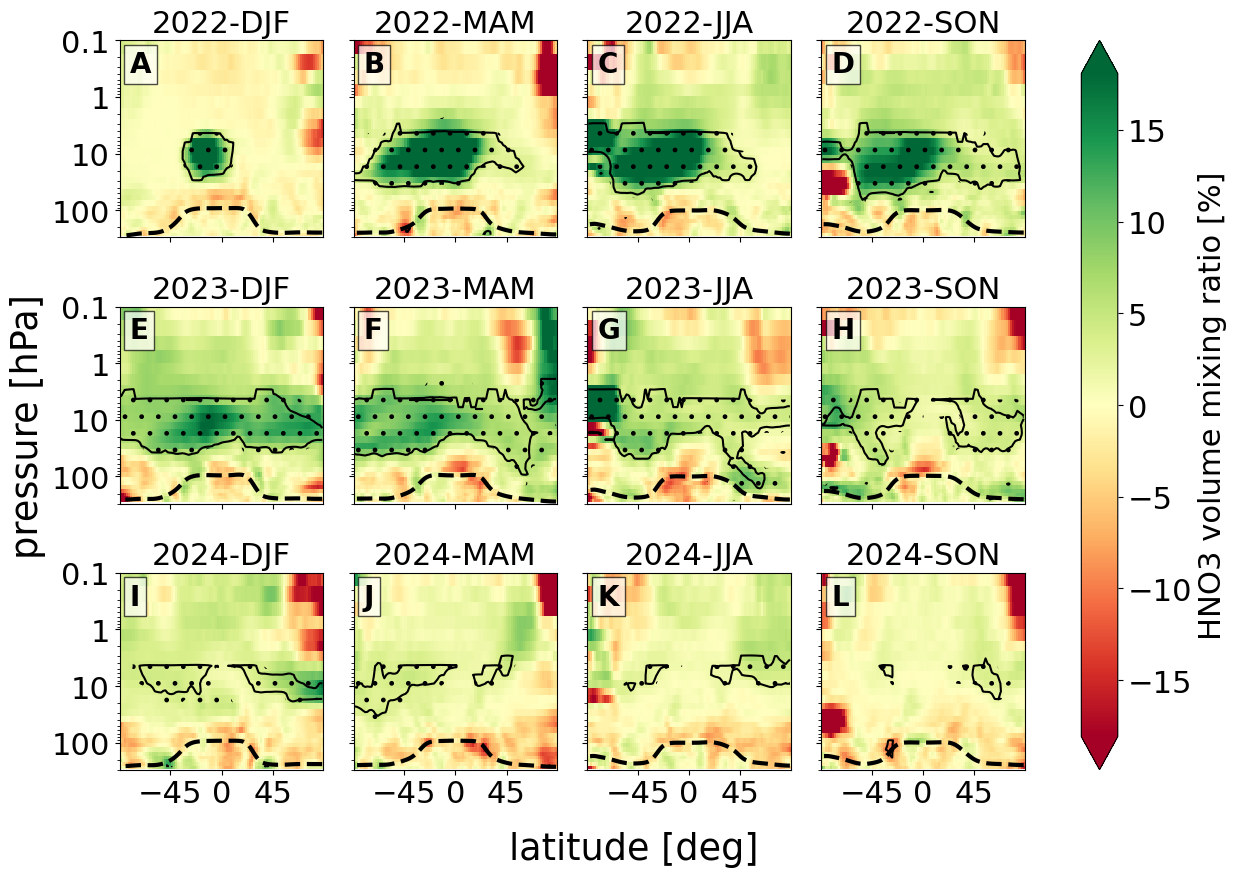

In [561]:
p = diff[:-1].plot(
    x="lat", col="time", yincrease=False, col_wrap=4, robust=True, cmap="RdYlGn"
)
levs = [5, 10, 20, 50]
nl = len(levs)

p.data = arr
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=levs,
    linewidths=np.linspace(1, 3, nl),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[-50, -20, -10, -5],
    linewidths=np.linspace(3, 1, nl),
    linestyles="dashed",
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)

u_pv = xr_multipletest(diff_pv)[1]
p.data = diff_pv  # u_pv #ttest_1samp(diff,'time')
kwargs = dict(
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[".", None]
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contourf, "lat", "plev", **kwargs)

p.data = u_pv  # xr_multipletest(diff_pv)[1]#o3_pv
kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    # linewidths=np.linspace(1, 4, 4),
)
p.map_dataarray(xr.plot.contour, "lat", "plev", **kwargs)


p.set_titles("{value}")
p.set_xlabels(" ")
p.set_ylabels(" ")
p.fig.supxlabel("latitude [deg]")
p.fig.supylabel("pressure [hPa]")

plt.ylim(300, .1)
plt.yscale("log")

for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_xticks([-45, 0, 45])
    ax.plot(lat, da_w_tpp.sel(**sel_dict), 'k--', lw  = 3)

outfile = f"{sel_var}_time-evolution-diff_mm_zon-htt-new-globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")